<a href="https://colab.research.google.com/github/Adrok24/Proyecto-T-VAE/blob/branch_2/TVAE_refactor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-datasets==1.2.0

In [ ]:
from google.colab import files
from google.colab import drive
from os.path import join
ROOT = '/content/drive'
drive.mount(ROOT)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Layer, Dense, LSTM, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
import pandas as pd
import pickle

tf.random.set_seed(1234)
pd.options.display.max_colwidth = 100

In [ ]:
## Vamos a bajarnos el dataset de dialogos de peliculas de Cornell University
# folder = '/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/'
folder = '/content/drive/My Drive/Colab Notebooks/desafio final/'

path_to_corpus = os.path.join(folder, 'train_corpus_v3.csv')
path_to_corpus

'/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/train_corpus_v3.csv'

In [ ]:
PROJ = '/content/repository/' # This is a custom path.
PROJECT_PATH = join(ROOT, PROJ)

GIT_USERNAME = "Adrok24"
GIT_REPOSITORY = "Proyecto-T-VAE"

!rm -r "{PROJECT_PATH}"
!mkdir '{PROJECT_PATH}'
!git clone https://github.com/{GIT_USERNAME}/{GIT_REPOSITORY}.git "{PROJECT_PATH}"



rm: cannot remove '/content/repository21/': No such file or directory
Cloning into '/content/repository21'...
remote: Enumerating objects: 116, done.
remote: Counting objects: 100% (116/116), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 314 (delta 62), reused 66 (delta 26), pack-reused 198
Receiving objects: 100% (314/314), 46.57 MiB | 28.20 MiB/s, done.
Resolving deltas: 100% (144/144), done.


In [ ]:
from importlib.machinery import SourceFileLoader
problem_module = SourceFileLoader('tvae_module', join(PROJECT_PATH,'tvae_model/__init__.py')).load_module()


In [ ]:
from tvae_module import *

In [ ]:
data = pd.read_csv(path_to_corpus, index_col=0)

In [ ]:
data.sample(10)

,line,len,book,genre,category,Sentimiento
78083,las aguas de este mar de antigua y suave música,49,_como_fueron_-_Eloy_Sanchez_Rosillo,poesía,Book,POS
189549,"por eso , fráulein . . . echó una mirada en torno a la habitación que sería de ella",93,El_anillo_-_Danielle_Steel,Novelas,Book,NEU
120586,tengo que pensarlo y discutirlo con mi marido,47,El_viaje_-_Danielle_Steel,Novelas,Book,NEU
283244,todo es absolutamente predecible y bastante repugnante,56,El_rancho_-_Danielle_Steel,Novelas,Book,NEG
165152,"prosiguió page , sin dejar de escrutarlas",45,Accidente_-_Danielle_Steel,Novelas,Book,NEU
152719,"@name pasó por la recepción del hotel y thomas , el conserje , lo reconoció enseguida y se a...",128,El_beso_-_Danielle_Steel,Novelas,Book,POS
236254,"detestaba estar allí , detestaba lo que significaba y lo que les habían hecho",81,honor_del_silencio_-_Danielle_Steel,Novelas,Book,NEG
105133,creo que serás una abogada estupenda,38,Deseos_concedidos_-_Danielle_Steel,Novelas,Book,POS
146331,no pueden ser cosas tan importantes que tengas que marcharte justo ahora,72,Regreso_a_casa_-_Allison_Leigh,Novelas,Book,NEG
85249,"como el @name fénix , resurjo de mis cenizas",48,Susurros_del_Alma_-_Alec_Blackhell,poesía,Book,NEU


In [ ]:
data.shape

(316618, 6)

In [ ]:
data.iloc[0:5,0]

0             bestiario es el primer libro de relatos que @name cortázar publica con su auténtico nombre
2    sorpresa o incomodidad son  ,  en cada texto  ,  un condimento que se agrega al placer indescrip...
4                                                                 a @name  ,  que gustaba de mis relatos
5    almorzábamos a mediodía  ,  siempre puntuales ya no quedaba nada por hacer fuera de unos pocos p...
6    nos resultaba grato almorzar pensando en la casa profunda y silenciosa y cómo nos bastábamos par...
Name: line, dtype: object

In [ ]:
path_to_tokenizer = os.path.join(folder, 'tokenizer.pkl')
with open(path_to_tokenizer, 'rb') as tk_pkl:
        tokenizer = pickle.load(tk_pkl)

### Preprocesamiento

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['line'], data['genre'], test_size=0.20, random_state=42, stratify=data['genre'])
print('X_train: ',X_train.shape, 'X_test: ',X_test.shape, 'y_train: ',y_train.shape, 'y_test: ',y_test.shape)

X_train:  (253294,) X_test:  (63324,) y_train:  (253294,) y_test:  (63324,)


In [ ]:
data_train = pd.concat([X_train, y_train],axis=1)

In [ ]:
data_train

,line,genre
316417,¡ quieta ! ¡ conviene para tu carrera de artista !,Novelas
327518,supongo que podría deshacerme de mis preciosos muebles y modernizarlo un poquito,Novelas
93461,había cuatro hombres inclinados sobre su cuerpo,Novelas
33290,contra la almohada de algas y saliva,cortazar
331773,se alejaron a toda prisa antes de decir nada,Novelas
...,...,...
94357,@name lo pensó durante un minuto y luego se encogió de hombros,Novelas
216365,yo echaría muchísimo de menos a @name si no pudiera verlo en toda la semana,Novelas
244428,@name sonrió para sus adentros al ver la cara que ponía su madre,Novelas
56692,intentar asegurarse la fidelidad de una voluntad libre es incompatible con el amor a un ser libre,filosofia


In [ ]:
VOCAB_SIZE = tokenizer.vocab_size

In [ ]:
VOCAB_SIZE

8189

In [ ]:
## el tokenizador tiene dos metodos: encode y decode:
print(tokenizer.encode("cantar"))
print(tokenizer.decode(tokenizer.encode("cantar")))

[4969]
cantar


In [ ]:
sample_string = 'todo lo que nos desvela'

tokenized_string = tokenizer.encode(sample_string)
print ('Tokenizada {}'.format(tokenized_string))

original_string = tokenizer.decode(tokenized_string)
print ('Original: {}'.format(original_string))

for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer.decode([ts])))

assert original_string == sample_string

Tokenizada [50, 14, 3, 74, 3740, 778]
Original: todo lo que nos desvela
50 ----> todo 
14 ----> lo 
3 ----> que 
74 ----> nos 
3740 ----> desv
778 ----> ela


In [ ]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64
MAX_LENGTH = 32

In [ ]:
data_tokens = tokenize_and_filter_df(data_train, tokenizer, MAX_LENGTH)

In [ ]:
data_tokens

,line,len,genre
0,"[64, 7234, 8030, 1522, 6949, 7965, 29, 81, 3434, 2, 5241, 66]",12,Novelas
1,"[614, 3, 282, 7038, 664, 28, 2, 192, 2858, 20, 5856, 20, 6, 4792, 2944, 14, 13, 1079, 2725, 8044]",20,Novelas
2,"[22, 456, 385, 2034, 53, 73, 18, 1267]",8,Novelas
3,"[280, 4, 5900, 7965, 2, 7126, 106, 6, 975, 479]",10,cortazar
4,"[10, 7740, 104, 5, 175, 4138, 100, 2, 255, 241]",10,Novelas
...,...,...,...
249844,"[7997, 9, 14, 429, 173, 13, 7326, 6, 218, 10, 4189, 2, 1516]",13,Novelas
249845,"[65, 1113, 62, 5110, 2, 157, 8030, 12, 9, 38, 11, 540, 2499, 7, 175, 4, 1105]",17,Novelas
249846,"[7997, 9, 446, 29, 43, 5299, 20, 26, 123, 4, 285, 3, 1858, 18, 317]",15,Novelas
249847,"[5168, 3869, 10, 4, 1387, 1732, 450, 2, 21, 4857, 2002, 23, 6350, 2000, 5862, 16, 8, 436, 5, 13,...",22,filosofia


In [ ]:
# paddeamos
data_lines = tf.keras.preprocessing.sequence.pad_sequences(
    data_tokens.line.tolist(), maxlen=MAX_LENGTH, padding='post')
  
data_lines[0]

array([  64, 7234, 8030, 1522, 6949, 7965,   29,   81, 3434,    2, 5241,
         66,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [ ]:
print('Tamaño vocabulario: {}'.format(VOCAB_SIZE))
print('frases: {}'.format(len(data_lines)))

Tamaño vocabulario: 8189
frases: 249849


In [ ]:
# Tomamos la mayor cantidad de frases que sea multiplo de [BATCH_SIZE] para no generar problemas en el entrenamiento
FINAL_LINES = int(len(data_lines) / BATCH_SIZE) * BATCH_SIZE
FINAL_LINES

249792

In [ ]:
# Adapto para que de un multiplo del batch size (64)
data_lines = data_lines[0:FINAL_LINES]
len(data_lines)

249792

In [ ]:
# saco el token de start de los outputs
dataset = tf.data.Dataset.from_tensor_slices((data_lines,data_lines))

dataset = dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
#dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

### Modelo VAE

In [ ]:
from tensorflow.keras.models import Model
from contextlib import suppress


beta = K.variable(value=0.0)
beta._trainable = False


In [ ]:
# Hyper-parameters
NUM_LAYERS = 6
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.2
LATENT_SPACE = 32
A = 0.01
B = 10

encoder = encoder(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT, LATENT_SPACE, MAX_LENGTH)
decoder = decoder(VOCAB_SIZE, NUM_LAYERS, UNITS, D_MODEL, NUM_HEADS, DROPOUT, LATENT_SPACE, MAX_LENGTH)
# Instanciamos el modelo
model = VAEModel(
      encoder,
      decoder,
      a=A,
      b=B,
      vocab_size=VOCAB_SIZE,
      num_layers=NUM_LAYERS,
      units=UNITS,
      d_model=D_MODEL,
      num_heads=NUM_HEADS,
      dropout=DROPOUT,
      latent_space=LATENT_SPACE,
      tokenizer=tokenizer)

In [ ]:
# model.load_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5')

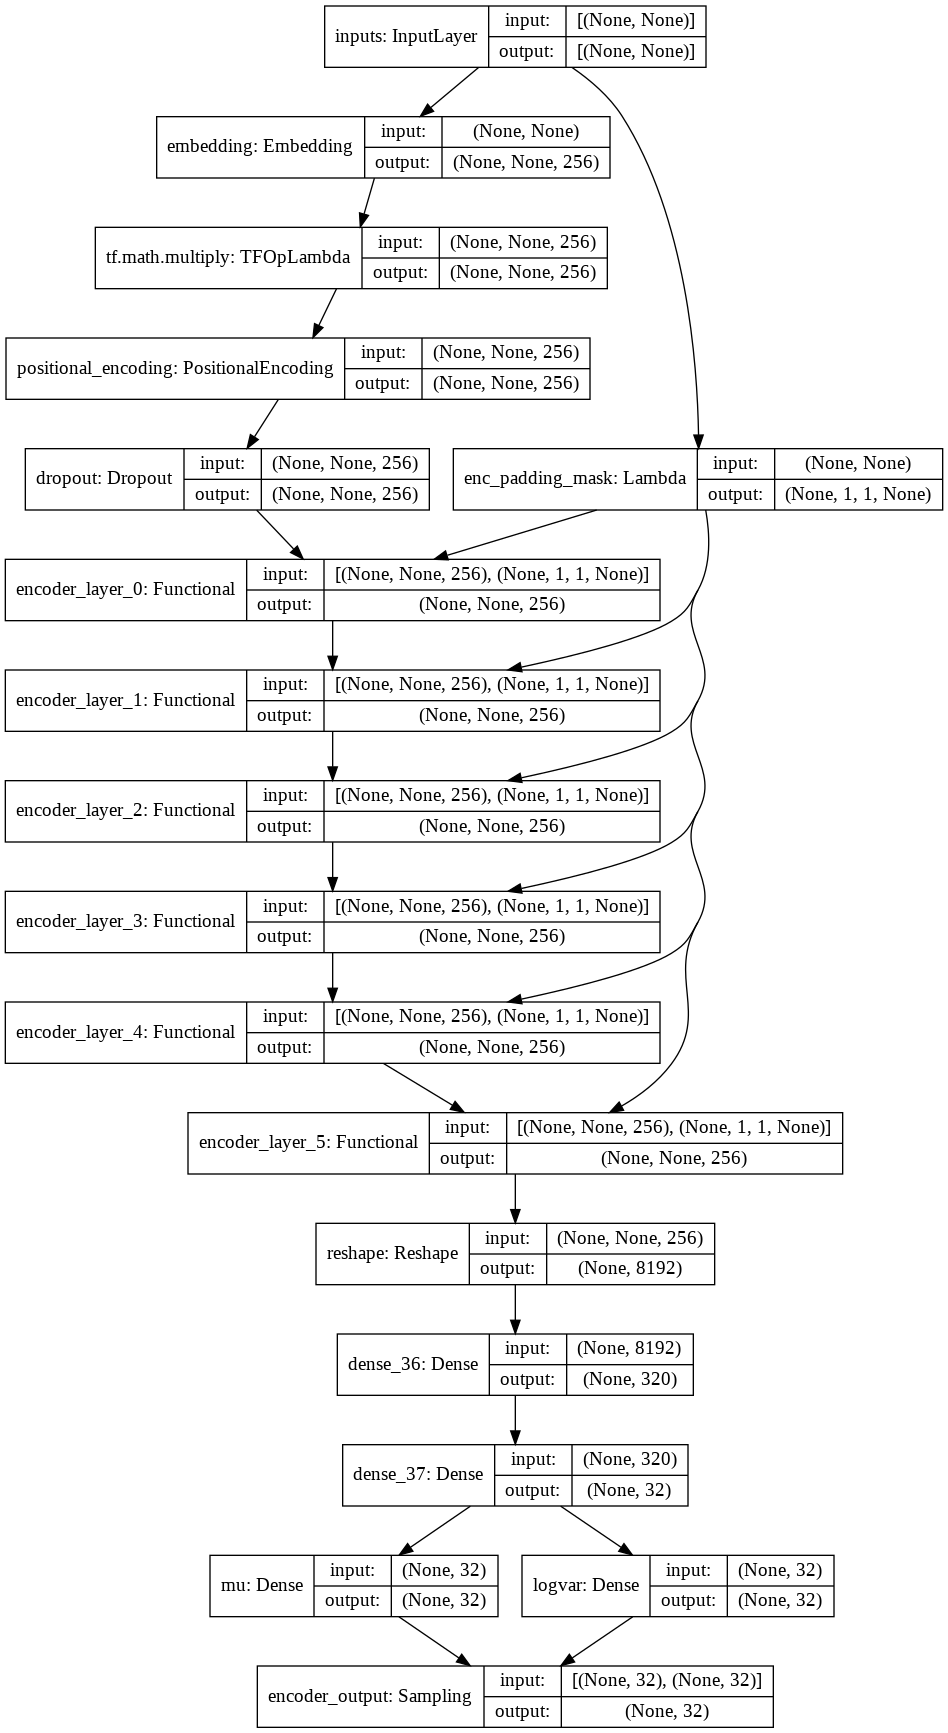

In [ ]:
#eo = VAEModel.encoder
tf.keras.utils.plot_model(encoder, show_shapes=True)

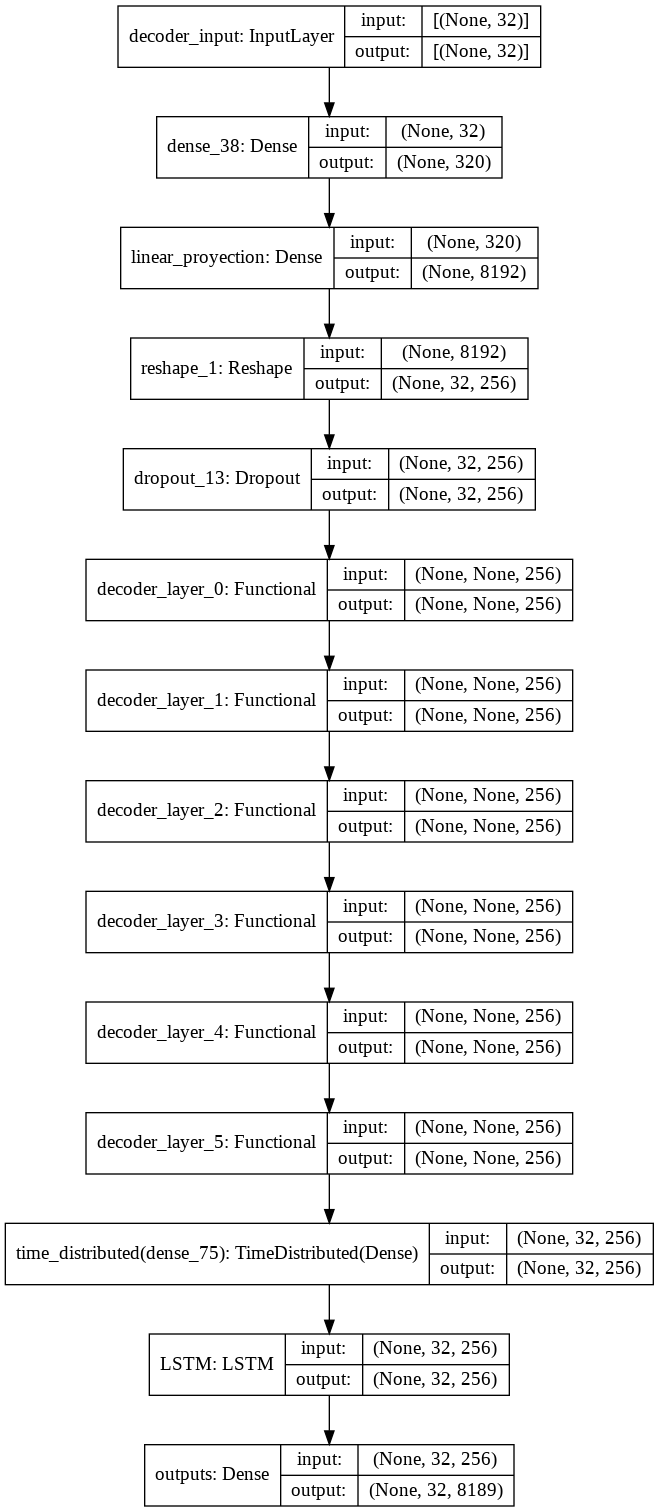

In [ ]:

tf.keras.utils.plot_model(decoder, show_shapes=True)
    

In [ ]:
from random import randint

from nltk.translate.chrf_score import sentence_chrf

# Ejemplo de la medida del accuracy del modelo / la loss

def loss_sentence_chrf(y_true, y_pred):
  chrf_acc_mean = 0
  with suppress(Exception):
    # print(y_pred.shape)
    preds = np.argmax(y_pred, axis=-1)
    # print(preds.shape)
    chrf_acc = []
    for index, pred in enumerate(preds, start=0):
      sentence_pred = tokenizer.decode(pred)
      sentence_true = tokenizer.decode(y_true[index])
      # print(sentence_pred,"|", sentence_true)
      # print('\n')
      " ".join([str(i) for i in pred])
      sentence_pred = " ".join([str(i) for i in pred])
      sentence_true = " ".join([str(i) for i in y_true[index].numpy()])

      # print('pred:',sentence_pred)
      # print('true:',sentence_true)
      # print('\n')
      chrf_acc = sentence_chrf(sentence_pred, sentence_true, min_len=2)

      loss = (1 - chrf_acc) * 100
      # print('loss:', loss)
      # print('acc:', chrf_acc)
      # print('\n')
      chrf_acc.append(chrf_acc)
      chrf_acc_mean = tf.reduce_mean(chrf_acc_mean)
  return chrf_acc_mean


y_true = tf.constant([data_lines[randint(0,data_lines.shape[0]) - 1] for _ in range(10)])
y_pred = model.predict(y_true)

loss_sentence_chrf(y_true, y_pred)

checkpoint_call


0

In [ ]:
from tensorflow.keras.callbacks import Callback, LambdaCallback


class EpochEndCallback(Callback): # Creamos una clase que herede de Callback

    def __init__(self, period=1): # Definimos los atributos que necesita la clase y los inicializamos en el constructor
        super(EpochEndCallback, self).__init__()
        self.period = period
    
    # Lo que buscamos es que cada cierta cantidad de epochs se genere un texto.
    def on_epoch_end(self, epoch, logs=None):
      if epoch % self.period == 0:
        print('Callback running', epoch)
        q_sample = data_lines[randint(0,data_lines.shape[0]) - 1]
        model.reconstruct(q_sample)
        if epoch % 20 == 0:
          model.save_weights('/content/drive/My Drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5', save_format='tf')          
          # y_true = tf.constant([data_lines[randint(0,data_lines.shape[0]) - 1] for _ in range(100)])
          # loss_sentence_chrf(y_true, y_pred)

# Instanciamos nuestro custom callback
eec = EpochEndCallback()

### Entrenamiento

In [ ]:
#defino un callback para actualizar epoch y generar variable de conteo de epochs
def count(epoch):
  K.set_value(beta, epoch)

counter = LambdaCallback(on_epoch_end=lambda epoch, log: count(epoch))

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)


In [ ]:
EPOCHS = 120

optimizer = tf.keras.optimizers.Adam(0.00001, beta_1=0.9, beta_2=0.999, 
                                     epsilon=1e-9) #for fine-tunning

model.compile(optimizer=optimizer)

history = model.fit(dataset, epochs=EPOCHS, callbacks=[eec, counter])

Epoch 1/120
ytrue: Tensor("IteratorGetNext:0", shape=(None, 32), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 32, 8189), dtype=float32)
ytrue: Tensor("IteratorGetNext:0", shape=(None, 32), dtype=int32) ypred: Tensor("decoder/outputs/BiasAdd:0", shape=(None, 32, 8189), dtype=float32)
  55/3903 [..............................] - ETA: 5:02 - loss: 8.5798 - reconstruction_loss: 8.5747 - kl_loss: 111.9301 - kl_weight: 4.5398e-05

KeyboardInterrupt: ignored

In [ ]:
# Grafico funcion de annealing
x = np.linspace(0,EPOCHS,10)

y = 1/(1+tf.exp(-A*x+10))


plt.figure(figsize=(20,8))

plt.plot(x,y,label='funcion de annealing')


plt.title('Funcion de annealing')

plt.xlabel('Epochs')
plt.ylabel('y')
plt.grid(alpha=.4,linestyle='--')

plt.legend()

plt.show()

In [ ]:
reconstruction_loss = history.history['reconstruction_loss']
loss = [np.mean(x) for x in model.history.history['loss']]
kl_loss = [np.mean(x) for x in model.history.history['kl_loss']]

epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, reconstruction_loss, label='reconstruction_loss')
plt.plot(epochs, loss, label='loss')
plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
# plt.ylim([20000, 40000])
# plt.xlim([30, 100])
plt.title('reconstruction_loss - kl_loss')
plt.legend()

plt

In [ ]:
#evolucion KL LOSS
kl_loss = [np.mean(x) for x in model.history.history['kl_loss']]

epochs = range(1, len(reconstruction_loss) + 1)

plt.figure(figsize=(20,8))
plt.plot(epochs, kl_loss, label='kl_loss')
plt.xticks(ticks=epochs)
plt.title('rkl_loss')
plt.legend()

plt

In [ ]:
# model.save_weights('/content/drive/My Drive/Colab Notebooks/desafio final/weights_corpus_v4.HDF5', save_format='tf')

## Testeamos

In [ ]:
errores = 0
for i in range(10):
  z_sampled = tf.random.normal(shape=(1,LATENT_SPACE))
  prediction = model.decode_sample(z_sampled,silent_reconstruct=True)
  if (prediction != None):
    print(prediction)
  else:
    errores += 1
print('\n')
print('\n','errores',errores)

In [ ]:
q_sample = data_lines[5]
model.reconstruct(q_sample)

In [ ]:
model.reconstruct_sentence("el devenir de los momentos")
model.reconstruct_sentence("las historias que nos contaron")
model.reconstruct_sentence("tu mirada milagrosa me salvó de su odio")
model.reconstruct_sentence("cayó como un rayo de luz que cegó al mundo") 
model.reconstruct_sentence("un hombre observaba desde el monte") 

In [ ]:
# Genera una funcion que se mueve por el espacio latente desde Oracion A hasta Oracion B
def linear_interpolate(sample1, sample2, cant_sentences = 5 ):
  print('desde:', tokenizer.decode(sample1),'\n')

  _,_,result1 = model.encoder(sample1.reshape(1,MAX_LENGTH,1))
  _,_,result2 = model.encoder(sample2.reshape(1,MAX_LENGTH,1))

  #Resto los valores del espacio latente y los divido por la cantidad de oracione que quiero generar
  vector = ((result1[0] - result2[0]).numpy()) / cant_sentences 

  for i in range(cant_sentences):
    result_int = result1 - vector * i
    print('step', str(i + 1) + ':', model.decode_sample(result_int, silent_reconstruct=True))

  print('')
  print('hasta:', tokenizer.decode(q_sample2))


In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B sampleadas del entrenamiento
q_sample1 = data_lines[randint(0,data_lines.shape[0]) - 1]
q_sample2 = data_lines[randint(0,data_lines.shape[0]) - 1]

linear_interpolate(q_sample1, q_sample2,6)


# Analisis Visual del espacio latente

In [ ]:
def encode_sentence(sentence):
    sentence = [sentence]
    sentence = tokenize_and_filter(sentence)
    sentence = sentence.reshape(MAX_LENGTH)
    return sentence

In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("un hombre observaba desde el monte")
q_sample2 = encode_sentence("deberas dejar cerrada aquella puerta")

linear_interpolate(q_sample1, q_sample2,5)

In [ ]:
#Generar oraciones intermedias desde una oración A hasta una B recibidas como imput por el Usuario
q_sample1 = encode_sentence("al despertarse una mañana, después de un sueño intranquilo")
q_sample2 = encode_sentence("se encontró en su cama transformado en un monstruoso insecto")

linear_interpolate(q_sample1, q_sample2,5)

In [ ]:
z_mean, _, _ = model.encoder.predict(dataset)

In [ ]:
# Analisis Visual del espacio latente
def plot_label_clusters(vae, z_mean, labels=None, z_fixed=0):
  # display a 2D plot of the digit classes in the latent space
  
  fig, axes = plt.subplots(4, 4, figsize=(16,16))
  fig.subplots_adjust(hspace=0.2)
  z = 0
  colors = ['b', 'c', 'y', 'm']
  for x in range(4):
    for y in range(4): 
      axes[x, y].scatter(z_mean[:, z_fixed], z_mean[:, z])
      axes[x, y].set_xlabel("z["+ str(z_fixed) +"] | z["+ str(z) +"]") 
      # axes[x, y].ylabel("z["+ str(i) +"]")
      z += 1



In [ ]:
plot_label_clusters(model, z_mean, data_tokens['genre'], 0)

In [ ]:
plot_label_clusters(model, z_mean, None, 5)